In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np

In [0]:
#detect is there cuda available for GPU training 
#otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
#load image by name
#resize the image and convert it to tensor
def image_loader(image_name, imsize):
	loader = transforms.Compose([transforms.Resize(imsize),
								 transforms.ToTensor()])
	image = Image.open(image_name) #read the image as [C, H, W]
	image = loader(image).unsqueeze(0) #put in a batch dimension in front for training purpose [1, C, H, W]

	return image.to(device, torch.float)

#display tensor as image
def imshow(tensor, title=None):
	#convert tensor to image
	unloader = transforms.ToPILImage()
	#clone the tensor so that we wont make change to the original tensor
	image = tensor.cpu().clone() 
	image = image.squeeze(0) # remove the batch dimension
	image = unloader(image)

	plt.imshow(image)
	if title is not None:
		plt.title(title)
	plt.pause(1)

In [0]:
#gram matrix for style loss
def gram_matrix(input):
	b, c, h, w = input.size()
	#b = batch = 1
	#c = channel of image
	#h = height, w=width

	features = input.view(b*c, h*w) #resize it to [c, h*w]

	G = torch.mm(features, features.t()) #gram matrix between features and the transposed ver

	#normalize the gram matrix 
	#by dividing the number of element in each feature maps
	return G.div(b*c*h*w)

#Content Loss
class ContentLoss(nn.Module):
	def __init__(self, target):
		super(ContentLoss, self).__init__()
		self.target = target.detach() #detach is used when you want to compute something that you dont want to differentiate

	def forward(self, input):
		self.loss = F.mse_loss(input, self.target) #compute mse loss between features of content image(self.target) and generated image(input)
		return input

#Style Loss
class StyleLoss(nn.Module):
	def __init__(self, target_features):
		super(StyleLoss, self).__init__()
		self.target = gram_matrix(target_features).detach()

	def forward(self, input):
		G = gram_matrix(input)
		self.loss = F.mse_loss(G, self.target)
		return input

#create module to normalize the input image so we can put it in nn.Sequentiol
class Normalization(nn.Module):
	def __init__(self, mean, std):
		super(Normalization, self).__init__()
		#reshape mean and std to [C, 1, 1] so they can
		#work directly with image tensor of shape [B x C x H x W]
		self.mean = torch.tensor(mean).view(-1, 1, 1) 
		self.std = torch.tensor(std).view(-1, 1, 1)

	def forward(self, img):
		#normalize the input image
		return (img - self.mean) / self.std

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
								style_img, content_img, 
								content_layers, style_layers):
	cnn = copy.deepcopy(cnn)

	#normalization module
	normalization = Normalization(normalization_mean, normalization_std).to(device)

	#save the content and style losses layer
	content_losses = []
	style_losses = []

	#assume the cnn is nn.Sequential, we make a new nn.Sequential
	#to put in modules that are supposed to be activated sequentially
	model = nn.Sequential(normalization)

	#name the layers
	block, i = 1, 1
	for layer in cnn.children():
		if isinstance(layer, nn.Conv2d):
			name = "conv{}_{}".format(block, i)
		elif isinstance(layer, nn.ReLU):
			name = "relu{}_{}".format(block, i)
			layer = nn.ReLU(inplace=False)
			i += 1
		elif isinstance(layer, nn.MaxPool2d): 
			name = "pool{}_{}".format(block, i)
			block += 1
			i = 1
		else:
			raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

		model.add_module(name, layer)

		if name in content_layers:
			target = model(content_img).detach()
			content_loss = ContentLoss(target)
			model.add_module("content_loss{}_{}".format(block, i), content_loss)
			content_losses.append(content_loss)

		if name in style_layers:
			target_features = model(style_img).detach()
			style_loss = StyleLoss(target_features)
			model.add_module("style_loss{}_{}".format(block, i), style_loss)
			style_losses.append(style_loss)

	#cut of later layers that we didnt use
	for i in range(len(model)-1, -1, -1):
		if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
			break
	model = model[:(i+1)]

	return model, style_losses, content_losses

def get_input_optimizer(input_image):
	# input image is a parameter that requires gradient, will change the input image
	optimizer = optim.LBFGS([input_image.requires_grad_()])
	return optimizer

def run_style_transfer(model, style_losses, content_losses,
						content_image, style_image, input_image,
						num_steps, style_weight=1000000, content_weight=1):
	print('Building the style transfer model..')
	optimizer = get_input_optimizer(input_image)

	#save images from each 50 iterations
	output_images = []

	print('Optimizing..')
	run = [0]
	while run[0] <= num_steps:

		def closure():
			#update the input image
			input_image.data.clamp_(0, 1)

			optimizer.zero_grad()
			model(input_image) #insert input image into model

			style_score = 0 
			content_score = 0

			for sl in style_losses:
				style_score += (1/5)*sl.loss
			for cl in content_losses:
				content_score += cl.loss

			style_score = style_weight * style_score
			content_score = content_weight * content_score

			loss = style_score + content_score
			loss.backward()

			#print out loss every 50 iterations
			run[0] += 1
			if run[0] % 50 == 0:
				print("run {}:".format(run))
				print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
				output_images.append(input_image.cpu().clone())
				imshow(input_image)
				print()

			return style_score + content_score

		optimizer.step(closure)

	#last update of input image
	input_image.data.clamp_(0, 1)

	return output_images

In [0]:
#Variable initialization
#desired layers for content and style loss
content_layers_default = ['conv3_1']
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
num_steps = 2000

In [0]:
#import vgg19 model (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

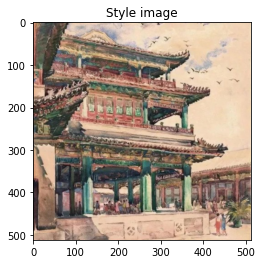

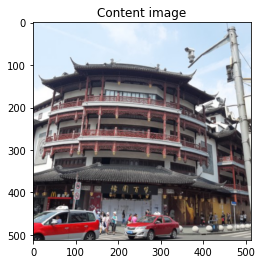

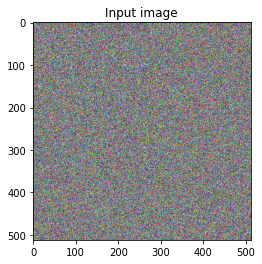

In [98]:
#VGG network are normalized with special values for mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

#size of images for GPU/CPU training
#loading of images
imsize = 512 if torch.cuda.is_available() else 256
style_image = image_loader("style4.jpeg", imsize)
content_image = image_loader("content7.jpg", imsize)
input_image = torch.randn(content_image.data.size(), device=device) #random noise

#error checking
assert style_image.size() == content_image.size(), "The size of style and content images have to be the same!"

#interactive plot
plt.ion()

#show images for training
plt.figure()
imshow(style_image, "Style image")

plt.figure()
imshow(content_image, "Content image")

plt.figure()

imshow(input_image, "Input image")

In [99]:
#get our own renamed model and losses that we needed
model, style_losses, content_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std,
																style_image, content_image, 
																content_layers_default, style_layers_default)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.325736 Content Loss: 7.184113


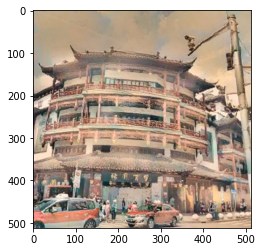


run [100]:
Style Loss : 2.308186 Content Loss: 7.149062


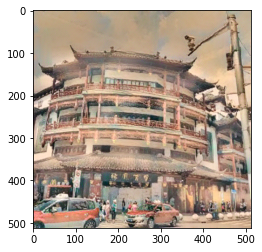


run [150]:
Style Loss : 2.294374 Content Loss: 7.121620


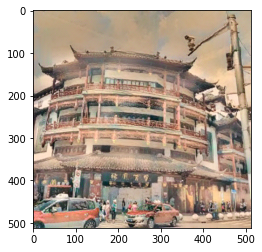


run [200]:
Style Loss : 2.283088 Content Loss: 7.093211


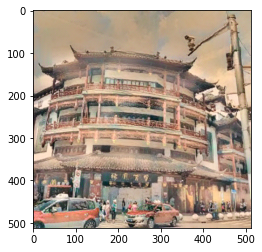


run [250]:
Style Loss : 2.281340 Content Loss: 7.063447


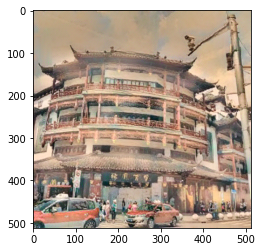


run [300]:
Style Loss : 2.262344 Content Loss: 7.036733


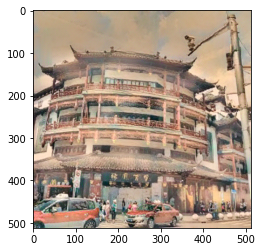


run [350]:
Style Loss : 2.251859 Content Loss: 7.010180


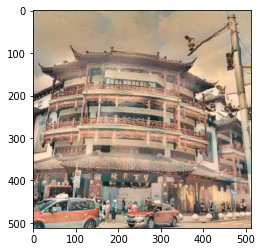


run [400]:
Style Loss : 2.243387 Content Loss: 6.984681


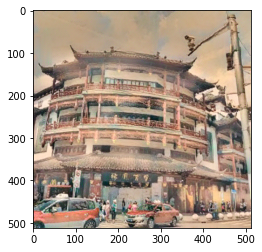


run [450]:
Style Loss : 2.235202 Content Loss: 6.960260


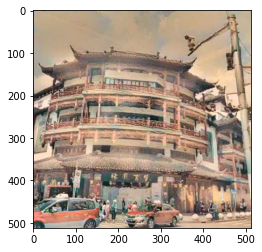


run [500]:
Style Loss : 2.228955 Content Loss: 6.933399


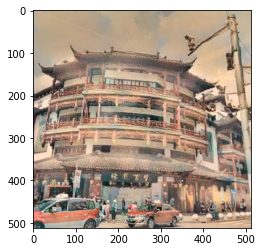


run [550]:
Style Loss : 2.223764 Content Loss: 6.909584


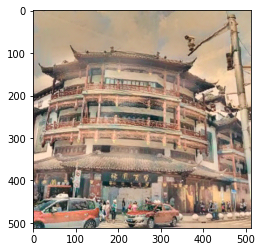


run [600]:
Style Loss : 2.215427 Content Loss: 6.886497


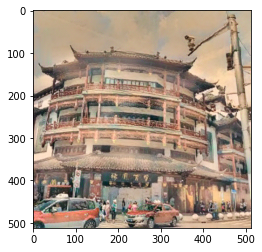


run [650]:
Style Loss : 2.205893 Content Loss: 6.863847


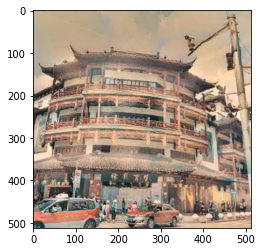


run [700]:
Style Loss : 2.199306 Content Loss: 6.846836


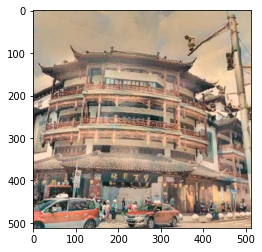


run [750]:
Style Loss : 2.215356 Content Loss: 6.824416


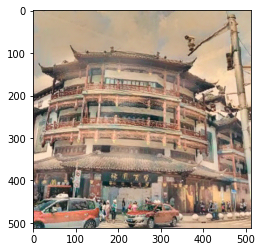


run [800]:
Style Loss : 2.174362 Content Loss: 6.810684


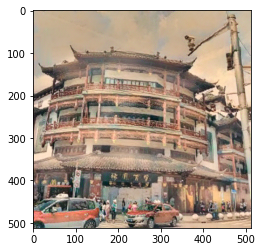


run [850]:
Style Loss : 2.198773 Content Loss: 6.810064


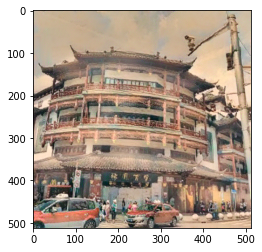


run [900]:
Style Loss : 2.149369 Content Loss: 6.778861


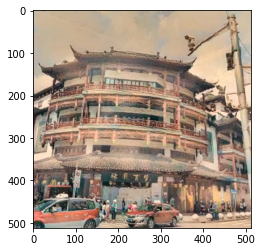


run [950]:
Style Loss : 2.131487 Content Loss: 6.766811


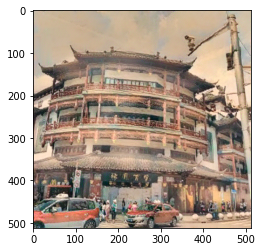


run [1000]:
Style Loss : 2.118814 Content Loss: 6.753101


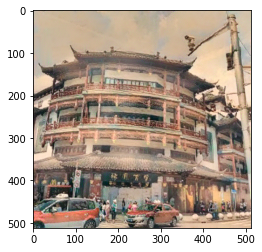


run [1050]:
Style Loss : 2.100351 Content Loss: 6.743577


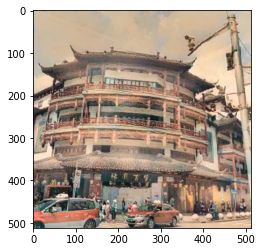


run [1100]:
Style Loss : 2.084849 Content Loss: 6.737297


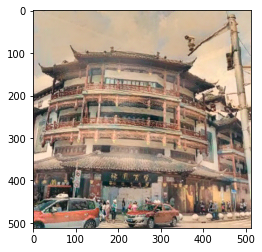


run [1150]:
Style Loss : 2.086272 Content Loss: 6.735607


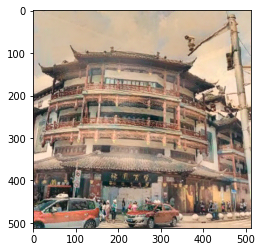


run [1200]:
Style Loss : 2.057586 Content Loss: 6.727367


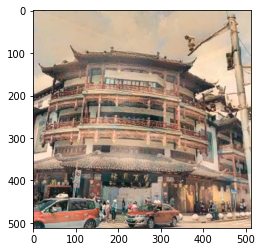


run [1250]:
Style Loss : 2.044999 Content Loss: 6.717528


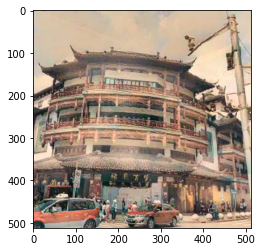


run [1300]:
Style Loss : 2.022679 Content Loss: 6.701796


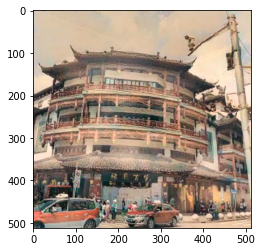


run [1350]:
Style Loss : 2.015898 Content Loss: 6.696546


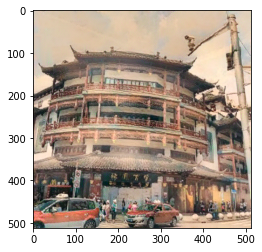


run [1400]:
Style Loss : 2.033357 Content Loss: 6.684170


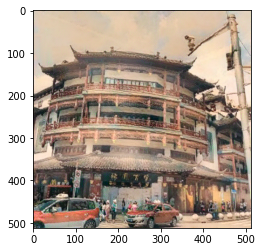


run [1450]:
Style Loss : 1.990218 Content Loss: 6.670179


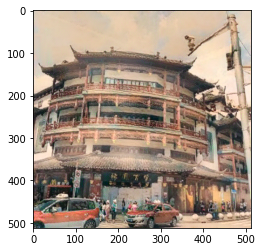


run [1500]:
Style Loss : 1.992955 Content Loss: 6.667741


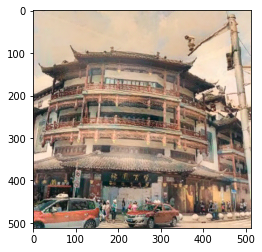


run [1550]:
Style Loss : 1.993971 Content Loss: 6.671247


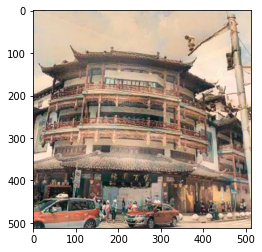


run [1600]:
Style Loss : 1.971751 Content Loss: 6.642872


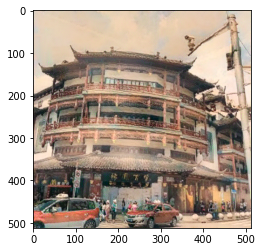


run [1650]:
Style Loss : 1.972337 Content Loss: 6.634166


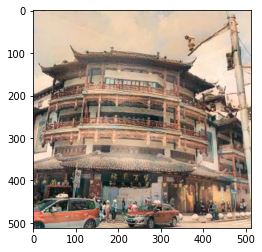


run [1700]:
Style Loss : 1.960029 Content Loss: 6.619992


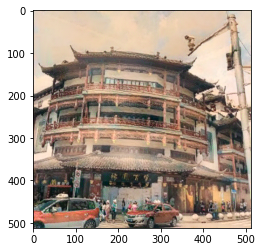


run [1750]:
Style Loss : 1.955354 Content Loss: 6.605651


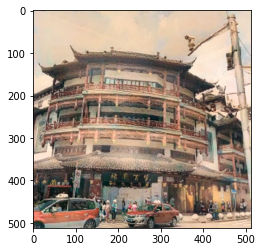


run [1800]:
Style Loss : 1.952238 Content Loss: 6.594663


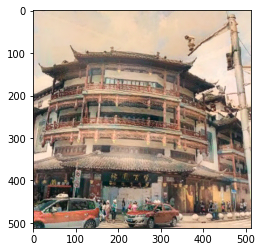


run [1850]:
Style Loss : 1.948132 Content Loss: 6.581877


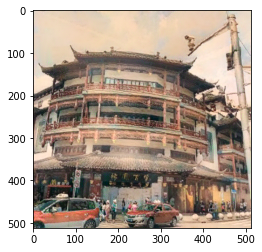


run [1900]:
Style Loss : 1.984377 Content Loss: 6.583063


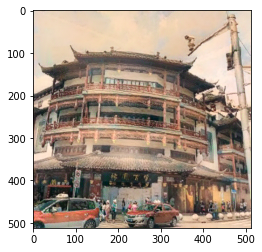


run [1950]:
Style Loss : 1.940654 Content Loss: 6.558685


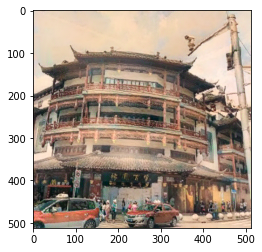


run [2000]:
Style Loss : 1.933572 Content Loss: 6.542658


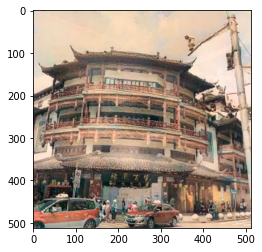

In [103]:
#optimizing the image
output_images = run_style_transfer(model, style_losses, content_losses,
							                              content_image, style_image, input_image,
						                              	num_steps, style_weight=1000000, content_weight=1)

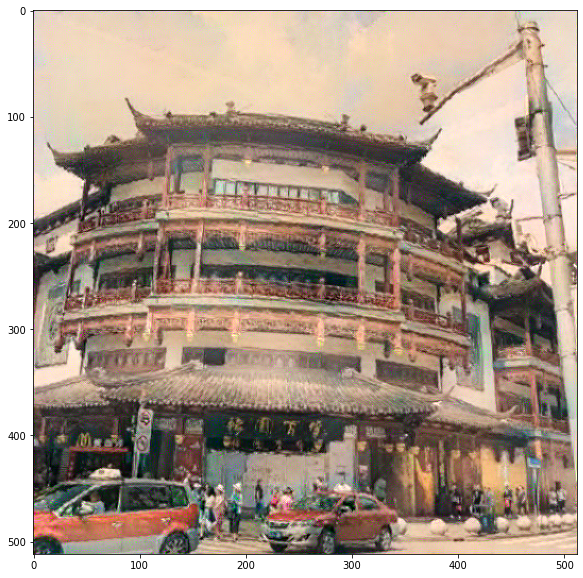

In [104]:
plt.figure(figsize=(10,10))
imshow(output_images[-1])

In [0]:
unloader = transforms.ToPILImage()
output_image = output_images[-1].cpu().clone()
output_image = output_image.squeeze(0)
output_image = unloader(output_image)

output_image.save("output742.png")